In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from einops import rearrange, einsum, reduce
import math, copy

In [13]:
path = './ex1data1.txt'
data = pd.read_csv(path, header=None, names=['Population', 'Profit'])
data.head()

,Population,Profit
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


In [14]:
data.describe()

,Population,Profit
count,97.000000,97.000000
mean,8.159800,5.839135
std,3.869884,5.510262
min,5.026900,-2.680700
25%,5.707700,1.986900
50%,6.589400,4.562300
75%,8.578100,7.046700
max,22.203000,24.147000


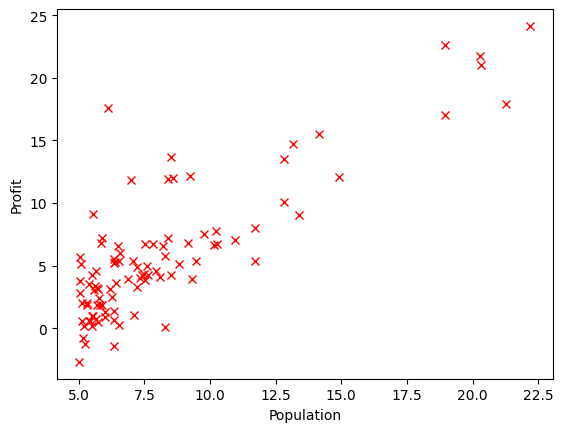

In [5]:
fig, ax = plt.subplots()
ax.plot(data['Population'],data['Profit'], 'rx')
ax.set_xlabel('Population')
ax.set_ylabel('Profit')
plt.show()

## Cost
$$J(w,b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)})^2 \tag{1}$$

where 
  $$f_{w,b}(x^{(i)}) = wx^{(i)} + b \tag{2}$$

In [15]:
def get_device() -> torch.device:
    """Try to use the GPU if possible, otherwise, use CPU."""
    if torch.mps.is_available():
        return torch.device(f"mps")
    else:
        return torch.device("cpu")

In [ ]:
def compute_cost(x, y, w, b):
    return reduce((x @ w + b - y).pow(2), "... -> ", "sum") / (
        2 * x.size()[0]
    )

In [104]:
def compute_cost_base(x,y, w,b):
    m = x.size()[0]
    cost_sum = 0 

    for i in range(m):
        f_wb = x[i][0] * w[0] + b[0] - y[i]
        cost = f_wb ** 2
        cost_sum += cost

    total_cost = cost_sum / (2 * m)
    return total_cost
    

In [ ]:
x = torch.tensor(data[['Population']].to_numpy(), dtype=torch.float32)
y = torch.tensor(data['Profit'].to_numpy(), dtype=torch.float32)
w = torch.tensor([0.5], dtype=torch.float32)
b = torch.tensor([0.3], dtype=torch.float32)

In [106]:
a = compute_cost_base(x,y,w,b)
print(a)
print("--------------")
a = compute_cost(x,y,w,b)
print(a)

tensor(9.1010)
--------------
tensor(9.1010)


## Gradient descent
$$\begin{align*} \text{repeat}&\text{ until convergence:} \; \lbrace \newline
\;  w &= w -  \alpha \frac{\partial J(w,b)}{\partial w} \tag{3}  \; \newline 
 b &= b -  \alpha \frac{\partial J(w,b)}{\partial b}  \newline \rbrace
\end{align*}$$
where, parameters $w$, $b$ are updated simultaneously.  
The gradient is defined as:
$$
\begin{align}
\frac{\partial J(w,b)}{\partial w}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)})x^{(i)} \tag{4}\\
  \frac{\partial J(w,b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)}) \tag{5}\\
\end{align}
$$

In [110]:
def compute_gradient_base(x, y, w, b):
    m = x.size()[0]
    dj_dw = 0
    dj_db = 0

    for i in range(m):
        f_wb = x[i][0] * w[0] + b[0] - y[i]
        dj_dw += f_wb * x[i][0]
        dj_db += f_wb

    dj_dw = dj_dw / m
    dj_db = dj_db / m 
    
    return dj_dw, dj_db 


In [144]:
def compute_gradient(x, y, w, b):    
    dj_dw = reduce((x @ w + b - y) @ x, "... -> ", "sum") / x.size()[0]
    dj_db = reduce(x @ w + b - y, "... -> ", "sum") / x.size()[0]

    return dj_dw, dj_db

In [108]:
a = torch.tensor([1,2,3])
b = torch.tensor([2,1,1])
c = a * b
print(c)

tensor([2, 2, 3])


In [146]:
a = compute_gradient_base(x,y,w,b)
print(a)
print("--------------")
a = compute_gradient(x,y,w,b)
print(a)

(tensor(-22.1789), tensor(-1.4592))
--------------
(tensor(-22.1789), tensor(-1.4592))


In [155]:
def gradient_descent(x, y, w_in, b_in, alpha, num_iters, cost_function, gradient_function):
    w = copy.deepcopy(w_in)
    b = copy.deepcopy(b_in)
    J_history = []
    p_history = []

    for i in range(num_iters):
        dj_dw, dj_db = gradient_function(x, y, w , b)
        b = b - alpha * dj_db                            
        w = w - alpha * dj_dw

        # save cost J and each iteration
        if i<100000:
            J_history.append( cost_function(x, y, w , b))
            p_history.append([w,b])

        if i% math.ceil(num_iters/10) == 0:
            print(f"Iteration {i:4}: Cost {J_history[-1].item():0.2e} ",
                  f"dj_dw: {dj_dw.item(): 0.3e}, dj_db: {dj_db.item(): 0.3e}  ",
                  f"w: {w.item(): 0.3e}, b:{b.item(): 0.5e}")
            
    return w, b, J_history, p_history
    

In [156]:
alpha = 0.01
iters = 1000
w_init = torch.tensor([0], dtype=torch.float32)
b_init = torch.tensor([0], dtype=torch.float32)

w, b, J_history, p_history = gradient_descent(x,y,w_init,b_init, alpha, iters, compute_cost, compute_gradient)

Iteration    0: Cost 6.74e+00  dj_dw: -6.533e+01, dj_db: -5.839e+00   w:  6.533e-01, b: 5.83913e-02
Iteration  100: Cost 5.48e+00  dj_dw: -6.010e-02, dj_db:  5.983e-01   w:  8.602e-01, b:-5.82540e-01
Iteration  200: Cost 5.17e+00  dj_dw: -5.019e-02, dj_db:  4.995e-01   w:  9.151e-01, b:-1.12950e+00
Iteration  300: Cost 4.96e+00  dj_dw: -4.190e-02, dj_db:  4.171e-01   w:  9.610e-01, b:-1.58616e+00
Iteration  400: Cost 4.82e+00  dj_dw: -3.498e-02, dj_db:  3.482e-01   w:  9.993e-01, b:-1.96744e+00
Iteration  500: Cost 4.71e+00  dj_dw: -2.921e-02, dj_db:  2.907e-01   w:  1.031e+00, b:-2.28577e+00
Iteration  600: Cost 4.64e+00  dj_dw: -2.439e-02, dj_db:  2.427e-01   w:  1.058e+00, b:-2.55156e+00
Iteration  700: Cost 4.59e+00  dj_dw: -2.036e-02, dj_db:  2.027e-01   w:  1.080e+00, b:-2.77347e+00
Iteration  800: Cost 4.56e+00  dj_dw: -1.700e-02, dj_db:  1.692e-01   w:  1.099e+00, b:-2.95874e+00
Iteration  900: Cost 4.53e+00  dj_dw: -1.419e-02, dj_db:  1.413e-01   w:  1.114e+00, b:-3.11343e+00


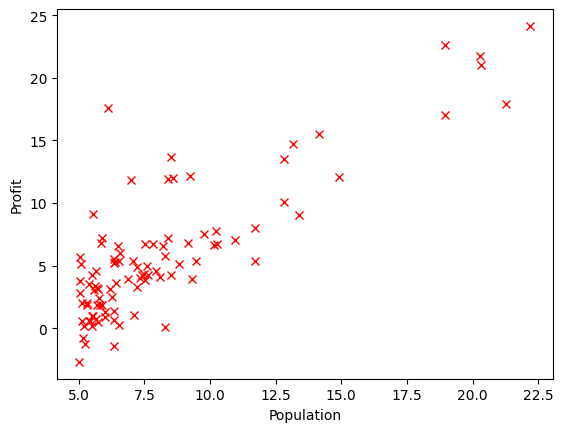

In [ ]:
x = 

fig, ax = plt.subplots()
ax.plot()
ax.plot(data['Population'],data['Profit'], 'rx', label='Traning Data')
ax.set_xlabel('Population')
ax.set_ylabel('Profit')
plt.show()